# Online Fraud Detection using GNN (Graph Neural Networks)

### About the Dataset
This dataset is taken from Kaggle via this link <a href="https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection">https://www.kaggle.com/datasets/jainilcoder/online-payment-fraud-detection</a>
    
```
To identify online payment fraud with machine learning, we need to train a machine learning model for classifying fraudulent and non-fraudulent payments. For this, we need a dataset containing information about online payment fraud, so that we can understand what type of transactions lead to fraud. For this task, I collected a dataset from Kaggle, which contains historical information about fraudulent transactions which can be used to detect fraud in online payments. Below are all the columns from the dataset I’m using here:

step: represents a unit of time where 1 step equals 1 hour
type: type of online transaction
amount: the amount of the transaction
nameOrig: customer starting the transaction
oldbalanceOrg: balance before the transaction
newbalanceOrig: balance after the transaction
nameDest: recipient of the transaction
oldbalanceDest: initial balance of recipient before the transaction
newbalanceDest: the new balance of recipient after the transaction
isFraud: fraud transaction
```

Let's get started by setting up the kaggle input directory to get our data from it

In [19]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/online-payment-fraud-detection/onlinefraud.csv


## Install and Import necessary packages

pip install torch_geometric
pip install networkx
pip install torchviz

In [20]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, recall_score
from torchviz import make_dot

## Let ' Load the Data and Explore it 

In [21]:
# Load the dataset
file_path = '/kaggle/input/online-payment-fraud-detection/onlinefraud.csv'
df = pd.read_csv(file_path)

## EDA:

In [22]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [23]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [24]:
df[df['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [25]:
Fraud=df[df['isFraud']==1]
Fraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [26]:
df['transaction_direction'] = np.where(df['amount'] > 0, 'Outgoing', 'Incoming')

In [27]:
bins = [0, 1000, 5000, 10000, 50000, np.inf]
labels = ['very_low', 'low', 'medium', 'high', 'very_high']
df['amount_bin'] = pd.cut(df['amount'], bins=bins, labels=labels, right=False)

In [28]:
df['nameOrig'].value_counts().head(50)

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
C1832548028    3
C1976208114    3
C2051359467    3
C1065307291    3
C1530544995    3
C17383104      2
C395795711     2
C1388763820    2
C1016934729    2
C1518561015    2
C1658461807    2
C709041245     2
C659608134     2
C1523592241    2
C2120304028    2
C1243795678    2
C142721306     2
C531630658     2
C1587125738    2
C2023074729    2
C1248315344    2
C142881435     2
C1159854452    2
C1628357145    2
C1026254665    2
C1716748090    2
C1879958008    2
C511264308     2
C539004364     2
C642414537     2
C998023735     2
C1032392212    2
C1644305871    2
C904625737     2
C161832559     2
C84922634      2
C876322114     2
C1200055473    2
C437815060     2
C1962457725    2
Name: count, dtype: int64

In [29]:
df['nameDest'].value_counts().head(50)

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
C977993101      96
C97730845       96
C392292416      95
C1899073220     92
C306206744      91
C1234776885     90
C1782113663     90
C998351292      89
C716083600      89
C909295153      88
C667346055      86
C1674899618     86
C1262822392     85
C1816757085     84
C1255024717     84
C453211571      84
C2006081398     83
C932583850      82
C1504109395     82
C991363637      82
C1303868418     81
C728526866      81
C214774813      80
C33524623       80
C1883840933     80
C1870252780     80
C766681183      80
C1721246982     80
C11003494       80
C1909597726     80
C662736689      79
C1167066016     79
C769342184      78
C423580937      77
C803116137      77
C1297685781     76
C1850180796     76
C1730752455     76
C863811613      75
C2049813033     75
Name: count, dtype: int64

In [30]:
df.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [31]:
type = df["type"].value_counts()
transactions = type.index
quantity = type.values
figure = px.pie(df, 
             values=quantity, 
             names=transactions,hole = 0.5, 
             title="Distribution of Transaction Type")
figure.show()

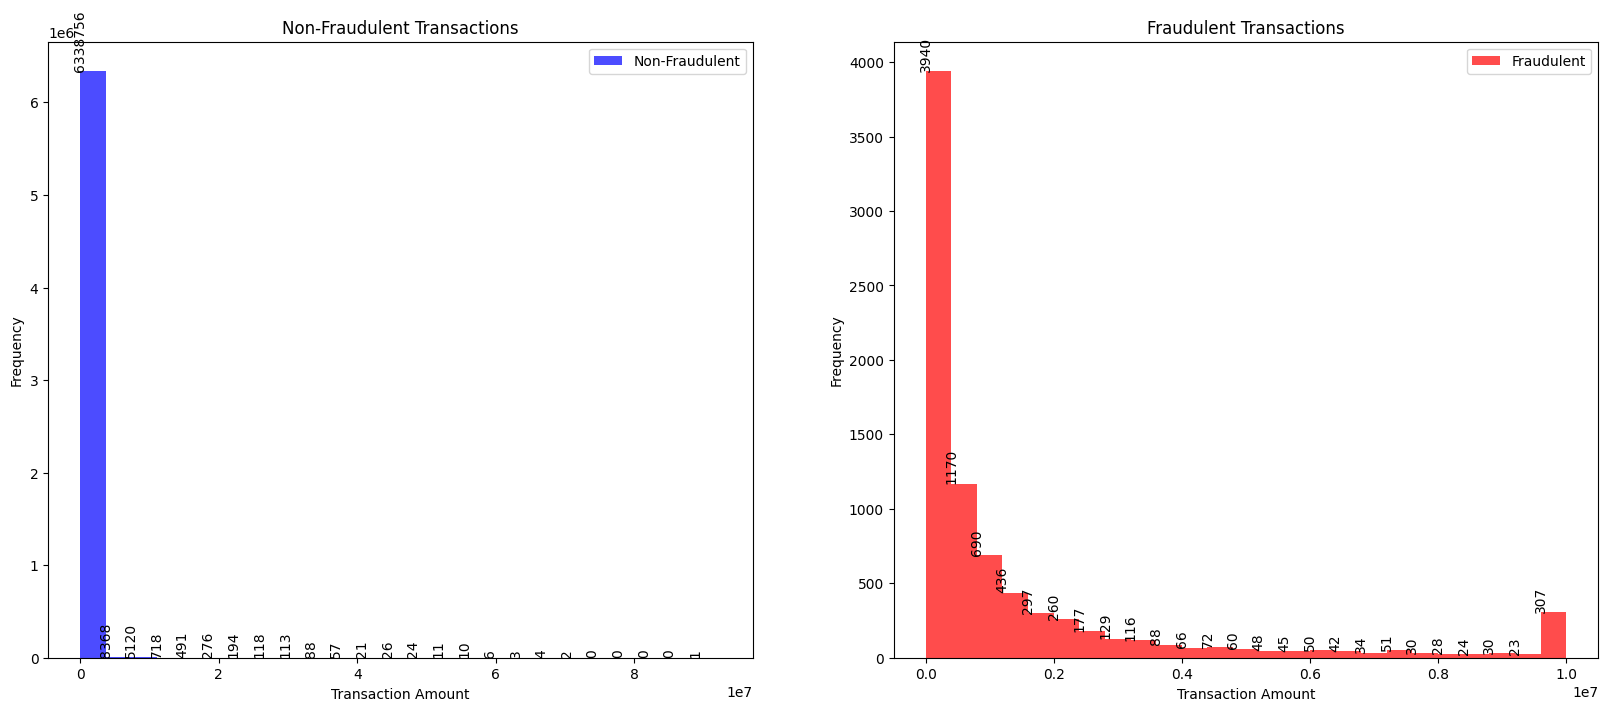

In [32]:
fraudulent_transactions = df[df['isFraud'] == 1]['amount']
non_fraudulent_transactions = df[df['isFraud'] == 0]['amount']

# Create two subplots
plt.figure(figsize=(20, 8))

# Plotting histogram for non-fraudulent transactions
plt.subplot(1, 2, 1)
n, bins, patches = plt.hist(non_fraudulent_transactions, bins=25, alpha=0.7, color='blue', label='Non-Fraudulent')
plt.title('Non-Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend()

# Annotating each bar with its count for non-fraudulent transactions (vertical text)
for count, bin_value, patch in zip(n, bins, patches):
    plt.text(bin_value + 0.5, count, str(int(count)), ha='center', va='bottom', rotation='vertical')

# Plotting histogram for fraudulent transactions
plt.subplot(1, 2, 2)
n, bins, patches = plt.hist(fraudulent_transactions, bins=25, alpha=0.7, color='red', label='Fraudulent')
plt.title('Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend()

# Annotating each bar with its count for fraudulent transactions (vertical text)
for count, bin_value, patch in zip(n, bins, patches):
    plt.text(bin_value + 0.5, count, str(int(count)), ha='center', va='bottom', rotation='vertical')

plt.show()

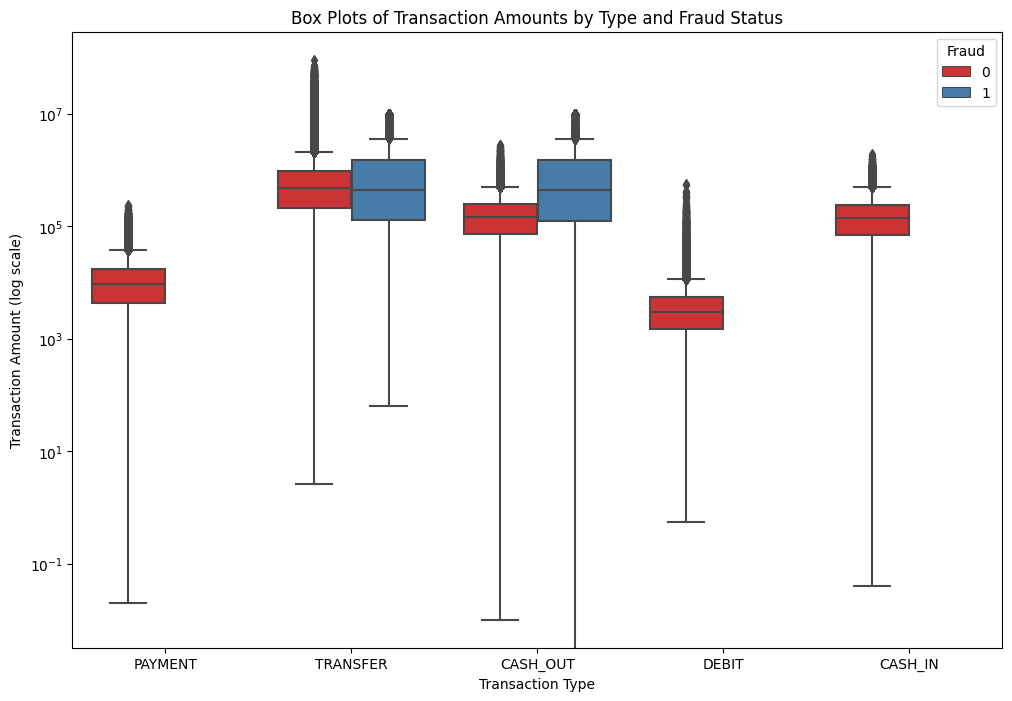

In [33]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='type', y='amount', data=df, hue='isFraud', palette='Set1')
plt.yscale('log')  # Use a logarithmic scale for better visualization if the amounts vary widely
plt.title('Box Plots of Transaction Amounts by Type and Fraud Status')
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount (log scale)')
plt.legend(title='Fraud', loc='upper right')
plt.show()

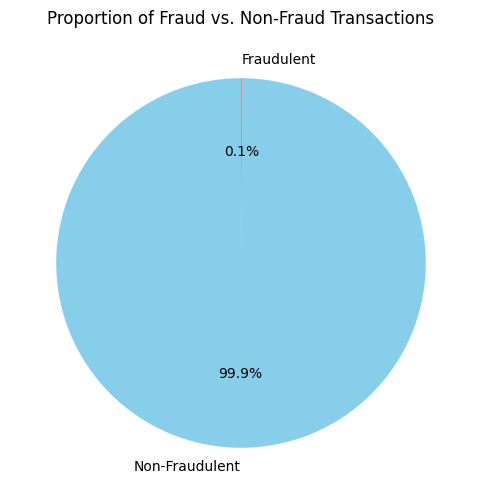

In [34]:
fraud_counts = df['isFraud'].value_counts()
labels = ['Non-Fraudulent', 'Fraudulent']

plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Proportion of Fraud vs. Non-Fraud Transactions')
plt.show()

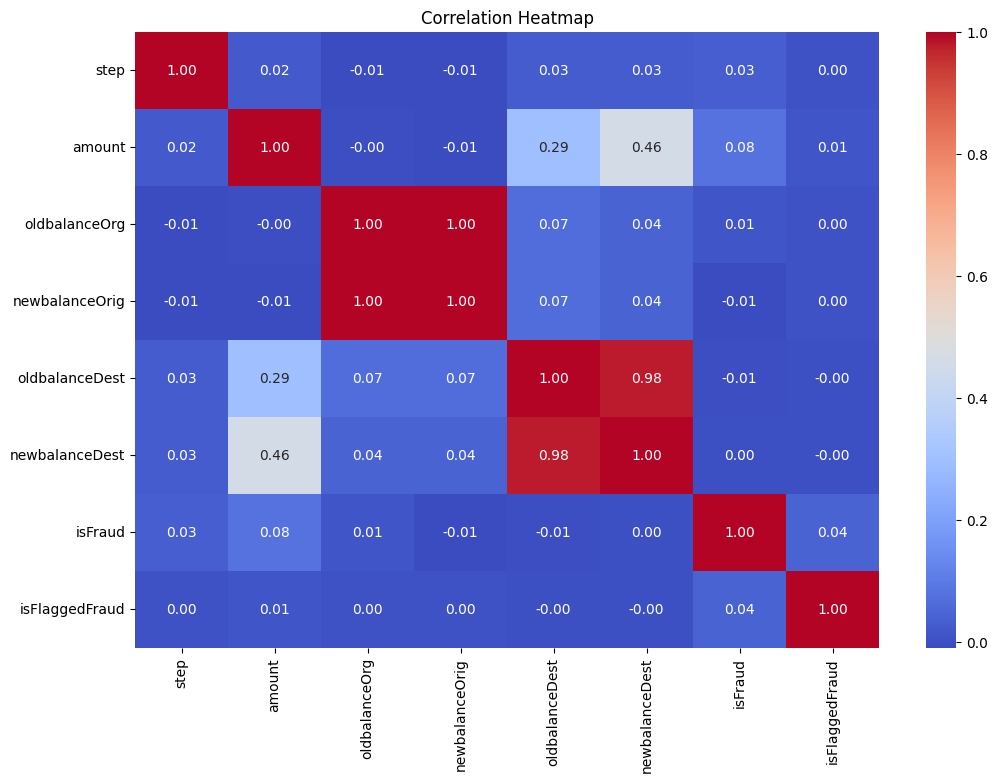

In [35]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix
correlation_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

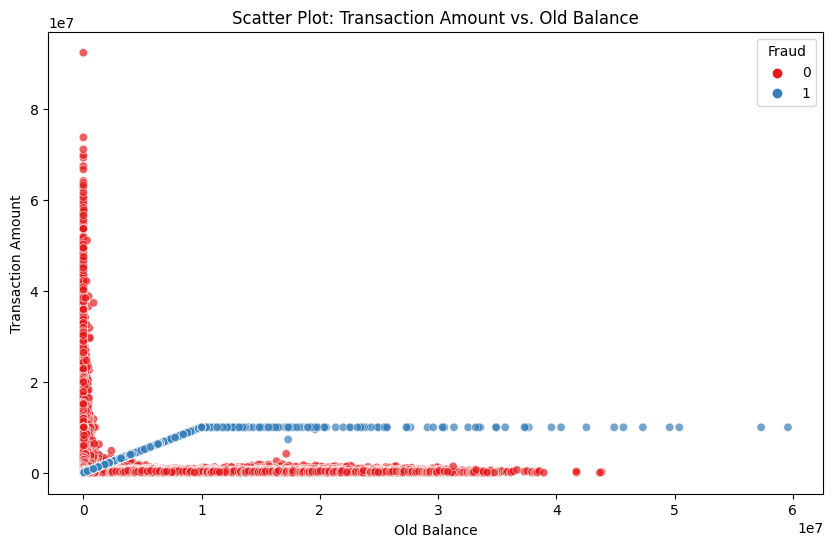

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oldbalanceOrg', y='amount', data=df, hue='isFraud', palette='Set1', alpha=0.7)
plt.title('Scatter Plot: Transaction Amount vs. Old Balance')
plt.xlabel('Old Balance')
plt.ylabel('Transaction Amount')
plt.legend(title='Fraud', loc='upper right')
plt.show()

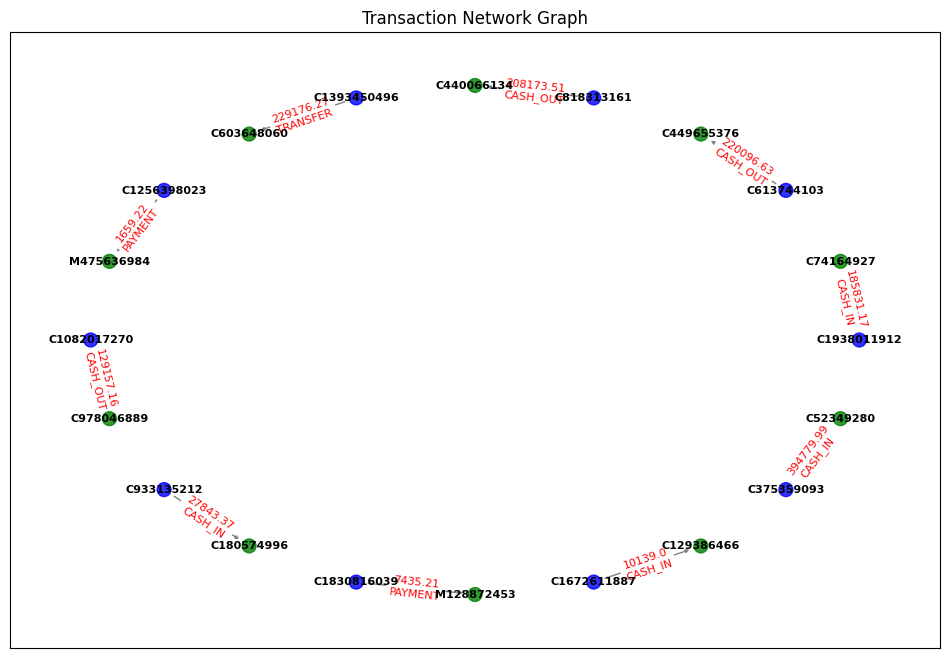

In [37]:
# Sample a subset of the data for visualization
subset_df = df.sample(n=10)  # Adjust the number as needed

# Create a directed graph
G = nx.DiGraph()

# Add nodes and their attributes
for _, row in subset_df.iterrows():
    for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
        G.add_node(row['nameOrig'], attr=row[col], color='blue', node_type='nameOrig', label=row['nameOrig'])
        G.add_node(row['nameDest'], attr=row[col], color='green', node_type='nameDest', label=row['nameDest'])
    G.add_edge(row['nameOrig'], row['nameDest'], amount=row['amount'], type=row['type'])

# Draw the graph with circular layout
plt.figure(figsize=(12, 8))
pos = nx.circular_layout(G)

# Extract node colors and types for drawing
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_types = [G.nodes[node]['node_type'] for node in G.nodes]

# Draw nodes with different colors based on types
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)

# Draw edges with labels for amount and type
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=5)
edge_labels = {(edge[0], edge[1]): f"{G.edges[edge]['amount']}\n{G.edges[edge]['type']}" for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Draw labels for nodes
labels = {node: G.nodes[node]['label'] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold')

plt.title('Transaction Network Graph')
plt.show()

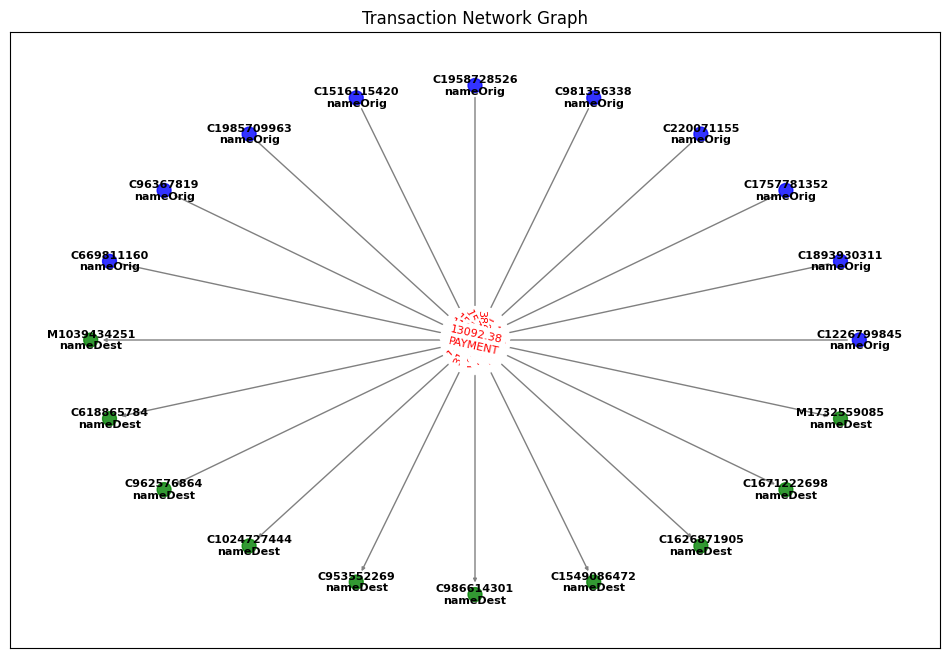

In [38]:
# Sample a subset of the data for visualization
subset_df = df.sample(n=10)  # Adjust the number as needed

# Create a directed graph
G = nx.DiGraph()

# Add nodes (users/accounts)
G.add_nodes_from(subset_df['nameOrig'], color='blue', node_type='nameOrig')
G.add_nodes_from(subset_df['nameDest'], color='green', node_type='nameDest')

# Add edges (transactions)
for _, row in subset_df.iterrows():
    G.add_edge(row['nameOrig'], row['nameDest'], amount=row['amount'], type=row['type'])

# Draw the graph with circular layout
plt.figure(figsize=(12, 8))
pos = nx.circular_layout(G)

# Extract node colors and types for drawing
node_colors = [G.nodes[node]['color'] for node in G.nodes]
node_types = [G.nodes[node]['node_type'] for node in G.nodes]

# Draw nodes with different colors based on types
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=0.8)

# Draw edges with labels for amount and type
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowsize=5)
edge_labels = {(edge[0], edge[1]): f"{G.edges[edge]['amount']}\n{G.edges[edge]['type']}" for edge in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

# Draw labels for nodes
labels = {node: f"{node}\n{node_type}" for node, node_type in zip(G.nodes, node_types)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', font_weight='bold')

plt.title('Transaction Network Graph')
plt.show()

In [39]:
df.isnull().sum()

step                     0
type                     0
amount                   0
nameOrig                 0
oldbalanceOrg            0
newbalanceOrig           0
nameDest                 0
oldbalanceDest           0
newbalanceDest           0
isFraud                  0
isFlaggedFraud           0
transaction_direction    0
amount_bin               0
dtype: int64

## Data Processing

In [40]:
# Encode categorical features
le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])
le_nameOrig = LabelEncoder()
df['nameOrig'] = le_nameOrig.fit_transform(df['nameOrig'])
le_nameDest = LabelEncoder()
df['nameDest'] = le_nameDest.fit_transform(df['nameDest'])
le_amount_bin = LabelEncoder()
df['amount_bin'] = le_amount_bin.fit_transform(df['amount_bin'])
le_transaction_direction = LabelEncoder()
df['transaction_direction'] = le_transaction_direction.fit_transform(df['transaction_direction'])


# Handle missing values (if any)
df.fillna(0, inplace=True)

# Normalize numerical features
scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(
    df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])

## Data Preparation

In [41]:
# Convert to graph data
# Create edge indices for transactions
edge_index = torch.tensor([
    df['nameOrig'].values,
    df['nameDest'].values
], dtype=torch.long)

# Node features
x = torch.tensor(df[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].values, dtype=torch.float)

# Labels
y = torch.tensor(df['isFraud'].values, dtype=torch.long)

# Create graph data object
graph_data = Data(x=x, edge_index=edge_index, y=y)

/tmp/ipykernel_758/78776373.py:3: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)



## Model Building

In [42]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(x.shape[1], 16)
        self.conv2 = GCNConv(16, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x, F.log_softmax(x, dim=1)

In [43]:
# Initialize the model, optimizer, and loss function
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out, pred = model(graph_data)
    loss = criterion(pred, graph_data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 2.891026020050049
Epoch 20, Loss: 0.08885998278856277
Epoch 40, Loss: 0.04335613176226616
Epoch 60, Loss: 0.034297797828912735
Epoch 80, Loss: 0.03072633594274521
Epoch 100, Loss: 0.02757473848760128
Epoch 120, Loss: 0.025141775608062744
Epoch 140, Loss: 0.023073725402355194
Epoch 160, Loss: 0.021072426810860634
Epoch 180, Loss: 0.0198750551789999


In [44]:
torch.save(model.state_dict(), 'gnn_fraud_detection_model.pth')

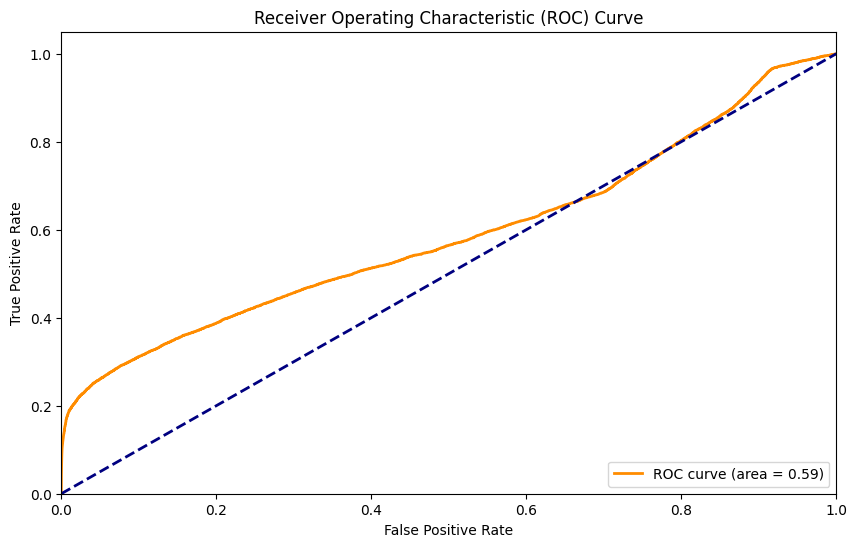

In [46]:
# ROC curve and classification report
model.eval()
with torch.no_grad():
    out, pred = model(graph_data)
    pred_labels = pred.argmax(dim=1).numpy()
    true_labels = graph_data.y.numpy()

fpr, tpr, _ = roc_curve(true_labels, pred[:, 1].numpy())
roc_auc = roc_auc_score(true_labels, pred[:, 1].numpy())

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [47]:
print("Classification Report:")
print(classification_report(true_labels, pred_labels))
print("Accuracy:", accuracy_score(true_labels, pred_labels))
print("Recall:", recall_score(true_labels, pred_labels))

Classification Report:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.00      0.00      0.00      8213

    accuracy                           1.00   6362620
   macro avg       0.50      0.50      0.50   6362620
weighted avg       1.00      1.00      1.00   6362620

Accuracy: 0.9987091795518198
Recall: 0.0


In [48]:
# Visualize the model architecture
model_dot = make_dot(loss, params=dict(model.named_parameters()))
model_dot.format = 'png'
model_dot.render('model_architecture')

'model_architecture.png'

## Save the Model and the metadta

In [49]:
# Save the trained model, scaler, and label encoders
import joblib
torch.save(model.state_dict(), 'gnn_fraud_detection_model.pth')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_type, 'label_encoder_type.pkl')
joblib.dump(le_nameOrig, 'label_encoder_nameOrig.pkl')
joblib.dump(le_nameDest, 'label_encoder_nameDest.pkl')
joblib.dump(le_amount_bin, 'label_encoder_amountbin.pkl')
joblib.dump(le_transaction_direction, 'label_encoder_transactiondirection.pkl')

['label_encoder_transactiondirection.pkl']